In [24]:
import os
import numpy as np
from torch.utils.data import (Dataset, DataLoader)
from sklearn import preprocessing
import torchvision
from PIL import Image
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
import torch
from imblearn.datasets import make_imbalance
from torchvision.models import resnet18

import gc


In [2]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)


In [3]:
path_to_dataset = os.path.join("data", "kaggle-MRI")
class_names = os.listdir(path_to_dataset)

NUM_CLASSES = len(class_names)
IMAGE_SIZE = (3, 256, 256)
LEARNING_RATE = 1e-4

N_WAY = 20  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

X = []
y = []


for item in class_names:
    path_to_class = os.path.join(path_to_dataset, item)
    paths = [os.path.join(path_to_class, file)
             for file in os.listdir(path_to_class)]
    X = X + paths
    y = y + [item]*len(paths)


le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

assert len(X) == len(y)
print(len(X), len(y))


4479 4479


In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, targets, transforms=None, label_transforms=None):
        self.data = data
        self.targets = targets
        self.transforms = transforms
        # self.label_transforms = label_transforms

    # for each sample
    def __getitem__(self, idx):
        image = Image.open(self.data[idx])

        # for grey scale images
        if image.size[0] != 3:
            rgbimg = Image.new("RGB", image.size)
            rgbimg.paste(image)
            image = rgbimg
        image = self.transforms(image)
        label = torch.tensor(self.targets[idx])
        return image, label

    def __len__(self):
        return len(self.targets)


In [5]:
# preprocessing pipeline

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(
        (IMAGE_SIZE[-2], IMAGE_SIZE[-1])),  # optional params: interpolation=torchvision.transforms.InterpolationMode.NEAREST
    torchvision.transforms.PILToTensor(),   # convert to tensor
    torchvision.transforms.ConvertImageDtype(   # convert to float
        torch.float32),
    torchvision.transforms.Normalize(   # normalize: out = (x - 0)/255
        [0, 0, 0], [255, 255, 255]),
    torchvision.transforms.Lambda(lambda x: x * 1),  # custom function
])


In [6]:
train_set, test_set = torch.utils.data.random_split(
    CustomDataset(data=X, targets=y, transforms=transforms), [0.95, 0.05])


In [7]:
# for inference

X_support, y_support = np.reshape(np.array(
    X)[train_set.indices], (-1, 1)), np.array(y)[train_set.indices]
X_support, y_support = make_imbalance(X_support, y_support, sampling_strategy={
    i: N_SHOT for i in range(NUM_CLASSES)})

support_set = CustomDataset(
    data=X_support[:, 0], targets=y_support, transforms=transforms)

support_loader = DataLoader(
    support_set, batch_size=N_SHOT*NUM_CLASSES, shuffle=True)


/home/khubayeeb_k/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [8]:

N_TRAINING_EPISODES = 10000


# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!

train_set.get_labels = lambda: y[train_set.indices]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_loader = DataLoader(test_set, batch_size=N_WAY*N_QUERY, shuffle=True)


In [9]:
from easyfsl.utils import plot_images, sliding_average


In [10]:
class PrototypicalNetworks(torch.nn.Module):
    def __init__(self, backbone: torch.nn.Module, support_set: DataLoader):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        # self.support_set = support_set

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in torch.unique(support_labels)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = torch.nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network, support_loader).cuda()


/home/khubayeeb_k/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khubayeeb_k/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

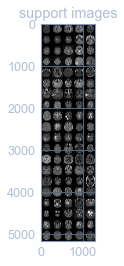

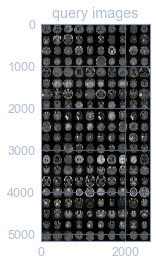

In [11]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images*255,
            "support images", images_per_row=N_SHOT)
plot_images(example_query_images*255, "query images", images_per_row=N_QUERY)


Tesing model without training


In [12]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{class_names[example_query_labels[i]]} / {class_names[example_predicted_labels[i]]}"
    )


Ground Truth / Predicted
Granuloma T1C+ / Meningioma T2
Granuloma T1C+ / Astrocitoma T2
Granuloma T1C+ / Granuloma T1C+
Granuloma T1C+ / Meningioma T2
Granuloma T1C+ / Schwannoma T1C+
Granuloma T1C+ / Meningioma T2
Granuloma T1C+ / Schwannoma T1C+
Granuloma T1C+ / Schwannoma T1C+
Granuloma T1C+ / Schwannoma T1C+
Granuloma T1C+ / Carcinoma T1
Granuloma T2 / Neurocitoma T1
Granuloma T2 / Neurocitoma T1
Granuloma T2 / _NORMAL T2
Granuloma T2 / Meningioma T1C+
Granuloma T2 / Carcinoma T1
Granuloma T2 / Granuloma T2
Granuloma T2 / Carcinoma T1
Granuloma T2 / Meningioma T1C+
Granuloma T2 / Carcinoma T1
Granuloma T2 / Meningioma T2
_NORMAL T1 / Neurocitoma T1
_NORMAL T1 / Schwannoma T1
_NORMAL T1 / Neurocitoma T1C+
_NORMAL T1 / _NORMAL T1
_NORMAL T1 / Meduloblastoma T2
_NORMAL T1 / Schwannoma T1
_NORMAL T1 / Astrocitoma T2
_NORMAL T1 / Meningioma T1
_NORMAL T1 / Astrocitoma T2
_NORMAL T1 / Neurocitoma T1C+
Meningioma T1C+ / Meningioma T1C+
Meningioma T1C+ / Meningioma T1C+
Meningioma T1C+ / M

In [26]:
_ = gc.collect()
# sanity check
for i in test_loader:
    print(i[0].size(), i[1].size())
    break
for i in support_loader:
    print(i[0].size(), i[1].size())
    break
for (support_images,
     support_labels,
     query_images,
     query_labels,
     class_ids) in train_loader:
    print(support_images.size(), support_labels.size(),
          query_images.size(), query_labels.size(), torch.Tensor(class_ids).size())
    break

_ = gc.collect()


torch.Size([200, 3, 256, 256]) torch.Size([200])
torch.Size([220, 3, 256, 256]) torch.Size([220])
torch.Size([100, 3, 256, 256]) torch.Size([100]) torch.Size([200, 3, 256, 256]) torch.Size([200]) torch.Size([20])


In [14]:

def evaluate(data_loader: DataLoader, supportSet: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    y_true = []  # support set labels
    y_pred = []  # predicted labels

    for batch in supportSet:
        support_images, support_labels = batch

        # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
        # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():

        for query_images, query_labels in tqdm(data_loader, total=len(data_loader), disable=True):

            scores = model(support_images.cuda(),
                           support_labels.cuda(),
                           query_images.cuda()).detach().data
            _, predictions = torch.max(scores, 1)

            correct = (predictions == query_labels.cuda()).sum().item()
            total = len(query_labels)

            total_predictions += total
            correct_predictions += correct

            y_true.extend(query_labels.data.tolist())
            y_pred.extend(predictions.data.tolist())

    print(correct_predictions, "/", total_predictions, " correct predictions.")
    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )
    return y_true, y_pred


_ = gc.collect()
y_true, y_pred = evaluate(test_loader, support_loader)


32 / 223  correct predictions.
Model tested on 2 tasks. Accuracy: 14.35%


With absolutely zero training on Omniglot images, and only 5 examples per class, we achieve around 86% accuracy! Isn't this a great start?

Now that you know how to make Prototypical Networks work, you can see what happens if you tweak it
a little bit (change the backbone, use other distances than euclidean...) or if you change the problem
(more classes in each task, less or more examples in the support set, maybe even one example only,
but keep in mind that in that case Prototypical Networks are just standard nearest neighbour).

When you're done, you can scroll further down and learn how to **meta-train this model**, to get even better results.


## Training a meta-learning algorithm

Let's use the "background" images of Omniglot as training set. Here we prepare a data loader of 40 000 few-shot classification
tasks on which we will train our model. The alphabets used in the training set are entirely separated from those used in the testing set.
This guarantees that at test time, the model will have to classify characters that were not seen during training.

Note that we don't set a validation set here to keep this notebook concise,
but keep in mind that **this is not good practice** and you should always use validation when training a model for production.


We will keep the same model. So our weights will be pre-trained on ImageNet. If you want to start a training from scratch,
feel free to set `pretrained=False` in the definition of the ResNet.

Here we define our loss and our optimizer (cross entropy and Adam, pretty standard), and a `fit` method.
This method takes a classification task as input (support set and query set). It predicts the labels of the query set
based on the information from the support set; then it compares the predicted labels to ground truth query labels,
and this gives us a loss value. Then it uses this loss to update the parameters of the model. This is a _meta-training loop_.


In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


In [16]:
_ = gc.collect()

# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,  # -> class ids
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels,
                         query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(
                all_loss, log_update_frequency))


100%|██████████| 10000/10000 [1:57:47<00:00,  1.42it/s, loss=0.000309]


In [17]:
y_true, y_pred = evaluate(test_loader, support_loader)


214 / 223  correct predictions.
Model tested on 2 tasks. Accuracy: 95.96%


                        precision    recall  f1-score   support

        Astrocitoma T1       1.00      0.80      0.89         5
      Astrocitoma T1C+       0.94      1.00      0.97        16
        Astrocitoma T2       1.00      0.75      0.86         8
          Carcinoma T1       1.00      1.00      1.00         4
        Carcinoma T1C+       1.00      1.00      1.00         8
          Carcinoma T2       1.00      1.00      1.00         8
         Ependimoma T1       1.00      1.00      1.00         3
       Ependimoma T1C+       1.00      0.50      0.67         2
         Ependimoma T2       1.00      1.00      1.00         3
      Ganglioglioma T1       0.00      0.00      0.00         0
    Ganglioglioma T1C+       0.00      0.00      0.00         0
      Ganglioglioma T2       1.00      1.00      1.00         1
          Germinoma T1       1.00      1.00      1.00         2
        Germinoma T1C+       1.00      1.00      1.00         2
          Germinoma T2       1.00      

/home/khubayeeb_k/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khubayeeb_k/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khubayeeb_k/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khubayeeb_k/.local/lib/p

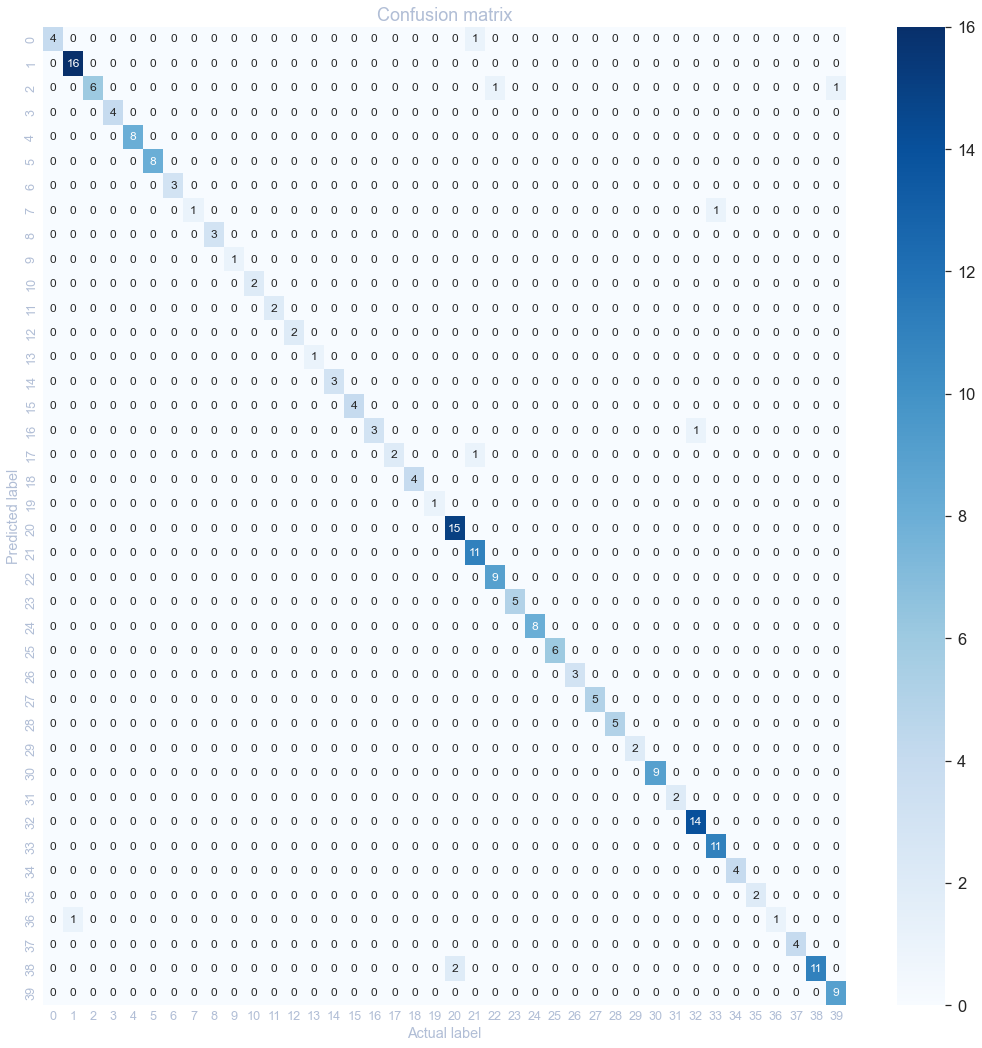

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

target_names = le.inverse_transform(np.arange(0, NUM_CLASSES))
cm = confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred,
      target_names=target_names, labels=np.arange(0, NUM_CLASSES)))

fig, ax = plt.subplots(figsize=(18, 18))
sns.set(font_scale=1.5)
sns.heatmap(pd.DataFrame(cm), cmap='Blues', annot=True,
            fmt='g', annot_kws={"size": 12}, ax=ax)  # font size
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.title("Confusion matrix")
plt.show()


## What have we learned?

-   What a Prototypical Network is and how to implement one in 15 lines of code.
-   How to use Omniglot to evaluate few-shot models
-   How to use custom PyTorch objets to sample batches in the shape of a few-shot classification tasks.
-   How to use meta-learning to train a few-shot algorithm.

## What's next?

-   Take this notebook in your own hands, tweak everything that there is to tweak. It's the best way to understand what does what.
-   Implement other few-shot learning methods, such as Matching Networks, Relation Networks, MAML...
-   Try other ways of training. Episodic training is not the only way to train a model to generalize to new classes!
-   Experiment on other, more challenging few-shot learning benchmarks, such as [CUB](http://www.vision.caltech.edu/visipedia/CUB-200.html)
    or [Meta-Dataset](https://github.com/google-research/meta-dataset).
-   If you liked this tutorial, feel free to ⭐ [give us a star on Github](https://github.com/sicara/easy-few-shot-learning) ⭐
-   **Contribute!** The companion repository of this notebook is meant to become a boilerplate, a source of useful code that
    that newcomers can use to start their few-shot learning projects.
